## Load package and data

In [2]:
from upath import UPath as Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nbvv

from serotiny.io.image import image_loader
from cytodata_aics.io_utils import rescale_image

20-Oct-22 15:51:19 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


In [3]:
mitocells = pd.read_csv('/home/aicsuser/cytodata-hackathon-base/data/mitocells.csv')

# Model

In [4]:
from serotiny.transforms.dataframe.transforms import split_dataframe
data_dir = "/home/aicsuser/cytodata-hackathon-base/data"

df = pd.read_csv(f"{data_dir}/mitocells.csv")
print(f'Number of cells: {len(df)}')
print(f'Number of columns: {len(df.columns)}')

Number of cells: 8179
Number of columns: 79


In [5]:
df["cell_stage"].value_counts()

M0               2000
M1M2             2000
M4M5             2000
M6M7_complete    1198
M3                981
Name: cell_stage, dtype: int64

In [6]:
import os
os.chdir("/home/aicsuser/cytodata-hackathon-base")

In [7]:
from datetime import datetime

# util to avoid referring to the same run unintentionally
now_str = lambda : datetime.now().strftime("%Y%m%d_%H%M%S")
run_name = f"teamx_single_channel_zproj_{now_str()}"
run_name = "teamx_single_channel_zproj_20221020_054245"

# Load and train

In [ ]:
print(run_name)

!serotiny train \
    model=Single_channel_VAE_model \
    data=Single_channel_VAE_dataloader \
    mlflow.experiment_name=vae_single_channel \
    mlflow.run_name={run_name} \
    trainer.gpus=[0] \
    trainer.max_epochs=50

teamx_single_channel_zproj_20221020_054245
[2022-10-20 05:42:48,884][pytorch_lightning.utilities.seed][INFO] - Global seed set to 42
[2022-10-20 05:42:48,885][serotiny.ml_ops.ml_ops][INFO] - Instantiating datamodule
[2022-10-20 05:42:51,357][serotiny.ml_ops.ml_ops][INFO] - Instantiating trainer
[2022-10-20 05:42:51,412][pytorch_lightning.utilities.rank_zero][INFO] - GPU available: True, used: True
[2022-10-20 05:42:51,413][pytorch_lightning.utilities.rank_zero][INFO] - TPU available: False, using: 0 TPU cores
[2022-10-20 05:42:51,413][pytorch_lightning.utilities.rank_zero][INFO] - IPU available: False, using: 0 IPUs
[2022-10-20 05:42:51,413][pytorch_lightning.utilities.rank_zero][INFO] - HPU available: False, using: 0 HPUs
[2022-10-20 05:42:51,413][serotiny.ml_ops.ml_ops][INFO] - Instantiating model
[2022-10-20 05:42:51,444][serotiny.networks.basic_cnn.basic_cnn][INFO] - Determined 'compressed size': 41496 for CNN
[2022-10-20 05:42:52,383][serotiny.networks.basic_cnn.basic_cnn][INFO] -

# Test and visualize latent space

In [8]:
!serotiny test \
    model=Single_channel_VAE_model \
    data=Single_channel_VAE_dataloader \
    mlflow.experiment_name=vae_single_channel \
    mlflow.run_name={run_name} \
    trainer/callbacks=vae \
    ++force=True

[2022-10-20 15:51:54,595][pytorch_lightning.utilities.seed][INFO] - Global seed set to 42
[2022-10-20 15:51:54,596][serotiny.ml_ops.ml_ops][INFO] - Instantiating datamodule
[2022-10-20 15:51:57,096][serotiny.ml_ops.ml_ops][INFO] - Instantiating trainer
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
[2022-10-20 15:51:57,237][pytorch_lightning.utilities.rank_zero][INFO] - GPU available: True, used: False
[2022-10-20 15:51:57,238][pytorch_lightning.utilities.rank_zero][INFO] - TPU available: False, using: 0 TPU cores
[2022-10-20 15:51:57,238][pytorch_lightning.utilities.rank_zero][INFO] - IPU available: False, using: 0 IPUs
[2022-10-20 15:51:57,238][pytorch_lightning.utilities.rank_zero][INFO] - HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1812:

In [9]:
import mlflow
from serotiny.ml_ops.mlflow_utils import download_artifact

mlflow.set_tracking_uri("http://mlflow.mlflow.svc.cluster.local")

with download_artifact("dataframes/embeddings.csv", experiment_name="vae_single_channel", run_name=run_name) as path:
    embeddings = pd.read_csv(path)
    
with download_artifact("dataframes/stats_per_dim_test.csv", experiment_name="vae_single_channel", run_name=run_name) as path:
    kl_per_dimension = pd.read_csv(path)

/opt/conda/lib/python3.10/site-packages/serotiny/ml_ops/mlflow_utils.py:144: FutureWarning: ``mlflow.tracking.fluent.list_experiments`` is deprecated. This method will be removed in a future release. Use ``search_experiments()`` instead.
  for _experiment in mlflow.list_experiments():
/opt/conda/lib/python3.10/site-packages/mlflow/tracking/fluent.py:1066: FutureWarning: ``mlflow.tracking.client.MlflowClient.list_experiments`` is deprecated. This method will be removed in a future release. Use ``search_experiments()`` instead.
  return MlflowClient().list_experiments(
/opt/conda/lib/python3.10/site-packages/serotiny/ml_ops/mlflow_utils.py:156: FutureWarning: ``mlflow.tracking.fluent.list_run_infos`` is deprecated. This method will be removed in a future release. Use ``search_runs()`` instead.
  for run_info in mlflow.list_run_infos(experiment_id=experiment_id):
/opt/conda/lib/python3.10/site-packages/mlflow/tracking/fluent.py:1599: FutureWarning: ``mlflow.tracking.client.MlflowClient.li

In [10]:
# Get dimension ranks based on KLD values
from cytodata_aics.vae_utils import get_ranked_dims
ranked_z_dim_list, mu_std_list, mu_mean_list = get_ranked_dims(kl_per_dimension, 0, 8)

In [11]:
ranked_z_dim_list = [f"mu_{i}" for i in ranked_z_dim_list]
updated_ranks = [f"mu_{i+1}" for i in range(8)]
embeddings = embeddings[[i for i in embeddings.columns if i in ranked_z_dim_list] + ['CellId']]

In [12]:
# Rank embeddings from 1 to 8
rename_cols = {}
for i, j in zip(ranked_z_dim_list, updated_ranks):
    rename_cols[i] = j
embeddings.rename(columns = rename_cols, inplace=True)
embeddings = embeddings.reindex(sorted(embeddings.columns), axis=1)

In [13]:
embeddings = embeddings.merge(mitocells[['CellId'] + 
                                                 [i for i in mitocells.columns if "shape_mode" in i] + 
                                                ['nuclear_volume', 'nuclear_height', 'nuclear_surface_area']], on = 'CellId')

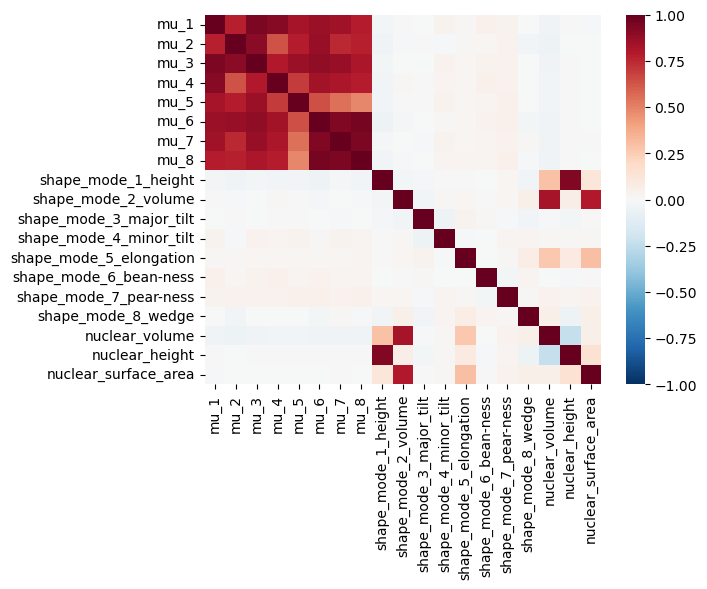

In [16]:
import matplotlib.pyplot as plt
sns.heatmap(embeddings[[i for i in embeddings.columns if i != 'CellId']].corr(), vmin=-1, vmax=1, cmap='RdBu_r')
plt.savefig('/home/aicsuser/latent_correlation.png')

<Figure size 640x480 with 0 Axes>